# Active Learning Framework Tutorial

This notebook provides a tutorial on how to use our active learning framework.

We will:
- Briefly introduce the core concepts: **Simulators**, **Emulators**, and various **Learner** strategies.
- Show how to set up a simple experiment using a sine function as the simulator.
- Demonstrate different active learning strategies (e.g. Random, A‑Optimal, D‑Optimal, E‑Optimal, and adaptive (PID‑based) methods).
- Visualize performance metrics during active learning.

**Note:** All the verbose class definitions are maintained in the source code. Here, we import them and focus on using them.

## 1. Imports

Import the necessary modules. Make sure you have installed all required packages.

(You might need to adjust the import paths according to your project structure.)

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import core classes from the source code.
from autoemulate.learners.base import (
    Simulator, Emulator, Distance, Random, A_Optimal, D_Optimal, E_Optimal,
    Adaptive_Distance, Adaptive_A_Optimal, Adaptive_D_Optimal, Adaptive_E_Optimal
)
from autoemulate.emulators import GaussianProcess
from autoemulate.experimental_design import LatinHypercube

## 2. Setting Up a Simple Experiment

In this section we define a simple simulator and an emulator:

- **Simulator:** A subclass that generates sine values.
- **Emulator:** A Gaussian Process emulator that “learns” the sine function.

These are minimal subclasses that use the imported framework classes.

In [4]:
# Define a simple sine simulator.
class Sin(Simulator):
    def sample_forward(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sin(X)

# Define an emulator using a dummy Gaussian Process.
class GP(Emulator):
    def __init__(self):
        self.model = GaussianProcess()
    def fit_forward(self, X: torch.Tensor, Y: torch.Tensor):
        self.model.fit(X, Y)
    def sample_forward(self, X: torch.Tensor):
        return torch.from_numpy(np.array(self.model.predict(X, return_std=True)))

# Create an instance of the simulator.
simulator = Sin()

# Prepare initial training data.
X_train = torch.linspace(0, 50, 5).reshape(-1, 1)
Y_train = torch.from_numpy(np.array(simulator.sample(X_train)))

## 3. Instantiating Active Learning Strategies

Here we instantiate several learners with different active learning strategies. Each learner combines a simulator and an emulator, along with its specific query approach.

For example:
- **Random:** Queries samples based on a fixed probability.
- **A‑Optimal, D‑Optimal, E‑Optimal:** Query based on different design criteria.
- **PID‑based learners:** Adapt the query threshold with PID control.

Note that the hyperparameters (e.g. query probability, threshold, PID gains) are provided during instantiation.

In [135]:
make_learners = lambda: [
    Random(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        p_query=0.25
    ),
    # Distance(
    #     simulator=simulator, emulator=GP(),
    #     X_train=X_train, Y_train=Y_train,
    #     threshold=0.25
    # ),
    # A_Optimal(
    #     simulator=simulator, emulator=GP(),
    #     X_train=X_train, Y_train=Y_train,
    #     threshold=1e-2
    # ),
    # D_Optimal(
    #     simulator=simulator, emulator=GP(),
    #     X_train=X_train, Y_train=Y_train,
    #     threshold=-4.1
    # ),
    # E_Optimal(
    #     simulator=simulator, emulator=GP(),
    #     X_train=X_train, Y_train=Y_train,
    #     threshold=1e-2
    # ),
    Adaptive_Distance(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=1e-1, Kp=1.0, Ki=1.0, Kd=1.0,
        key="rate", target=0.25,
        min_threshold=None, max_threshold=None,
        window_size=10
    ),
    Adaptive_A_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=1e-1, Kp=1.0, Ki=1.0, Kd=1.0,
        key="rate", target=0.25,
        min_threshold=0.0, max_threshold=1.0,
        window_size=10
    ),
    Adaptive_D_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=-4.0, Kp=1.0, Ki=1.0, Kd=1.0,
        key="rate", target=0.25,
        min_threshold=None, max_threshold=None,
        window_size=10
    ),
    Adaptive_E_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=0.75, Kp=1.0, Ki=1.0, Kd=1.0,
        key="rate", target=0.25,
        min_threshold=0.0, max_threshold=1.0,
        window_size=10
    )
]

## 4. Running an Active Learning Experiment

We simulate a stream of unlabeled data using Latin Hypercube sampling.
Each learner then processes the stream using its own query strategy.

After processing, we aggregate the metrics (such as MSE, R2 score, and design criteria) and visualize them.

In [137]:
# Generate a stream of input samples.
X_stream = torch.tensor(LatinHypercube([(0, 50)]).sample(500), dtype=torch.float32)

# Each learner processes the stream. (The `fit_samples` method updates the model and records metrics.)
data = list()
learners = list()
seeds = [0, 1]
for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    print(f'Trial with seed {seed}')
    for learner in make_learners():
        learner.fit_samples(X_stream)
        metrics = learner.summary
        metrics.update(dict(seed=seed, name=learner.__class__.__name__))
        data.append(metrics)
        learners.append(learner)

Trial with seed 0


Adaptive_E_Optimal: 100%|██████████| 500/500 [00:15<00:00, 32.17it/s, mse=0.0854, r2=0.829, rate=0.252, trace=0.0144, logdet=-4.24, max_eigval=0.0144, n_queries=126, score=0.0144, threshold=1, ep=0.00251, ei=0.0481, ed=-0.000507]       

Trial with seed 1



Adaptive_E_Optimal: 100%|██████████| 500/500 [00:15<00:00, 31.50it/s, mse=0.0854, r2=0.829, rate=0.252, trace=0.0144, logdet=-4.24, max_eigval=0.0144, n_queries=126, score=0.0144, threshold=1, ep=0.00251, ei=0.0481, ed=-0.000507]       


In [148]:
# Group by 'name' and aggregate using mean and standard deviation.
df = pd.DataFrame(data)
agg_df = df.groupby('name').agg({
    'r2_per_query': ['mean', 'std'],
    'mse_per_query': ['mean', 'std'],
    'trace_per_query': ['mean', 'std'],
    'logdet_per_query': ['mean', 'std'],
    'max_eigval_per_query': ['mean', 'std'],
    'auc_mse': ['mean', 'std']
}).reset_index()

agg_df = agg_df.sort_values(('r2_per_query', 'mean'), ascending=False)
agg_df

name r2_per_query           mse_per_query            \
                              mean       std          mean       std   
2   Adaptive_Distance     0.007749  0.000000      0.000886  0.000000   
1  Adaptive_D_Optimal     0.007248  0.000000      0.000618  0.000000   
0  Adaptive_A_Optimal     0.006754  0.000000      0.000644  0.000000   
4              Random     0.006694  0.000045      0.000611  0.000067   
3  Adaptive_E_Optimal     0.006577  0.000000      0.000678  0.000000   

  trace_per_query           logdet_per_query           max_eigval_per_query  \
             mean       std             mean       std                 mean   
2        0.000141  0.000000        -0.039202  0.000000             0.000141   
1        0.000136  0.000000        -0.035388  0.000000             0.000136   
0        0.000117  0.000000        -0.034456  0.000000             0.000117   
4        0.000119  0.000002        -0.033011  0.000617             0.000119   
3        0.000114  0.000000        -0.033670  0.000000             0.000114   

               auc_mse            
        std       mean       std  
2  0.000000  23.537447  0.000000  
1  0.000000  22.676760  0.000000  
0  0.000000  23.884880  0.000000  
4  0.000002  27.500525  0.857245  
3  0.000000  26.674433  0.000000

In [149]:
df = list()
for learner in learners:
    df.append(dict(
        name=learner.__class__.__name__,
        **learner.metrics
    ))

df = pd.DataFrame(df).groupby("name").agg(
    r2_mean = ("r2", lambda s: np.vstack(s).mean(axis=0).tolist()),
    r2_std  = ("r2", lambda s: np.vstack(s).std(axis=0).tolist())
)
df

,r2_mean,r2_std
name,,
Adaptive_A_Optimal,"[nan, nan, nan, -0.29329027689956977, -0.19029...","[nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Adaptive_D_Optimal,"[nan, -2.5306999808393287, -2.0825054351741854...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Adaptive_Distance,"[nan, -2.5306999808393287, -2.5306999808393287...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Adaptive_E_Optimal,"[nan, nan, nan, nan, -483.34965455656845, -0.3...","[nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Random,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


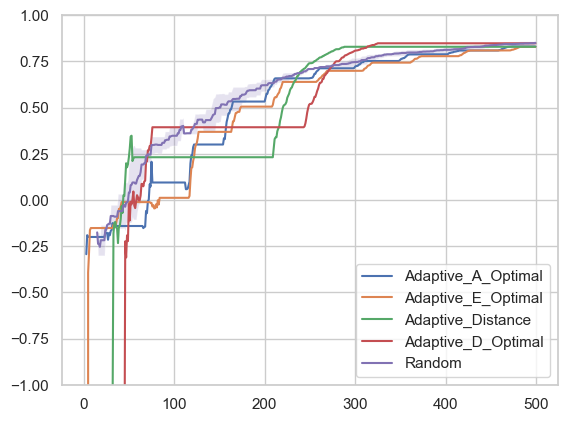

In [150]:
names = set([learner.__class__.__name__ for learner in learners])
for name in names:
    iterations = range(len(df['r2_mean'][name]))
    mean = np.array(df['r2_mean'][name])
    std = np.array(df['r2_std'][name])
    plt.plot(iterations, mean, label=name)
    plt.fill_between(iterations, mean - std, mean + std, alpha=0.2)
    plt.ylim(-1, 1)
plt.legend()
plt.show()